In [1]:
from numpy import *
import MDAnalysis as mda
import MDAnalysis.analysis.distances
from pylab import *
style.use('seaborn-poster')
import glob
import scipy.stats

In [2]:
EQPOINT=250



h2opath="data/water/solvent_included/"
pegpath="data/peg/solvent_included/"

#glob tprs
h2ogros=glob.glob(h2opath+"*.gro")
peggros=glob.glob(pegpath+"*.gro")

#glob tprs
h2otprs=glob.glob(h2opath+"*.tpr")
pegtprs=glob.glob(pegpath+"*.tpr")

#trjs
h2otrjs=glob.glob(h2opath+"*.xtc")
pegtrjs=glob.glob(pegpath+"*.xtc")

systemtprs=[h2otprs,pegtprs]
systemtrjs=[h2otrjs,pegtrjs]



resids_proper=list(arange(-4,67))+list(arange(69,238))
resids=list(arange(-4,67))+[nan,nan]+list(arange(69,238))
#get universes 
h2ou=[]
pegu=[]

for i in range(len(h2ogros)):
    h2ou.append(mda.Universe(h2ogros[i],h2otrjs[i]))
    #fix resids immediately
    h2ou[i].select_atoms("protein or resname CH6").residues.resids = resids_proper
for i in range(len(peggros)):
    pegu.append(mda.Universe(peggros[i],pegtrjs[i]))
    #fix resids immediately
    pegu[i].select_atoms("protein or resname CH6").residues.resids = resids_proper
    
    
#compile all the systems in one list
systems = [h2ou,pegu]
system_names = ['No-PEG','PEG']
#[]
#[tol-darkgreen,tol-darkblue,tol-bottompurple]
twoColour=["#332288","#882255"]
# Dark green,    
#sixColor=['#0A732D','#332288','#88CCEE',"#44AA99",'#882255','#D250BC']
#colorScheme=sixColor
colourScheme = twoColour
# Let's set up the selections for each trajectory by chain

# i want to make a list that has the sh2 domains selected in each sublist so that each one has 6 selections.
h2ou_fullprotein=[]
pegu_fullprotein=[]

h2ou_fullprotein_string=[]
pegu_fullprotein_string=[]


h2ou_notail=[]
pegu_notail=[]


h2ou_notail_string=[]
pegu_notail_string=[]


for i in range(len(h2otrjs)):
    h2ou_notail.append(h2ou[i].select_atoms("(protein or resname CH6) and resid 1:228"))
    h2ou_notail_string.append("(protein or resname CH6) and resid 1:228")
    h2ou_fullprotein.append(h2ou[i].select_atoms("(protein or resname CH6)"))
    h2ou_fullprotein_string.append("(protein or resname CH6)")
    
for i in range(len(pegtrjs)):
    pegu_notail.append(pegu[i].select_atoms("(protein or resname CH6) and resid 1:228"))
    pegu_notail_string.append("(protein or resname CH6) and resid 1:228")
    pegu_fullprotein.append(pegu[i].select_atoms("(protein or resname CH6)"))
    pegu_fullprotein_string.append("(protein or resname CH6)")

fullprotein_selections=[h2ou_fullprotein,pegu_fullprotein]
fullprotein_selections_string=[h2ou_fullprotein_string,pegu_fullprotein_string]
notail_selections = [h2ou_notail,pegu_notail]
notail_selections_string = [h2ou_notail_string,pegu_notail_string]



In [3]:
# Next lets count the atoms


all_total_residue_atom_counts=[]
for i in range(len(systems)):
    sub=[]
    for j in range(len(systems[i])):
        u = systems[i][j]
        
        atomCountsTimeseries = []
        for t in range(len(u.trajectory)):
            u.trajectory[t]
            contacts1=u.select_atoms("protein and around 3.5 resname CH6",updating=True)

            atomcounts = len(contacts1.atoms)
            
            atomCountsTimeseries.append(atomcounts)
        sub.append(atomCountsTimeseries)
    all_total_residue_atom_counts.append(sub)
        

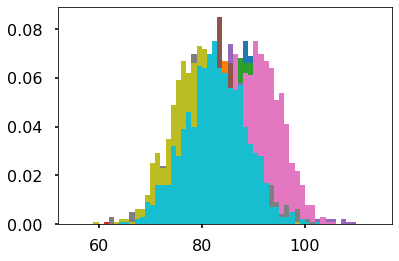

In [4]:
all_total_residue_atom_counts_hists=[]
for i in range(len(all_total_residue_atom_counts)):
    sub = []
    for j in range(len(all_total_residue_atom_counts[i])):
        
        a=hist(all_total_residue_atom_counts[i][j],bins = arange(55,115),density = True)
        
        sub.append(a[0]/len(systems[i][j].trajectory))
    all_total_residue_atom_counts_hists.append(sub)
    
    
system_avg_hist_y = []
system_sem_hist_y = []

for i in range(len(all_total_residue_atom_counts_hists)):
    system_avg_hist_y.append(mean(all_total_residue_atom_counts_hists[i],axis = 0))
    system_sem_hist_y.append(scipy.stats.sem(all_total_residue_atom_counts_hists[i],axis = 0))

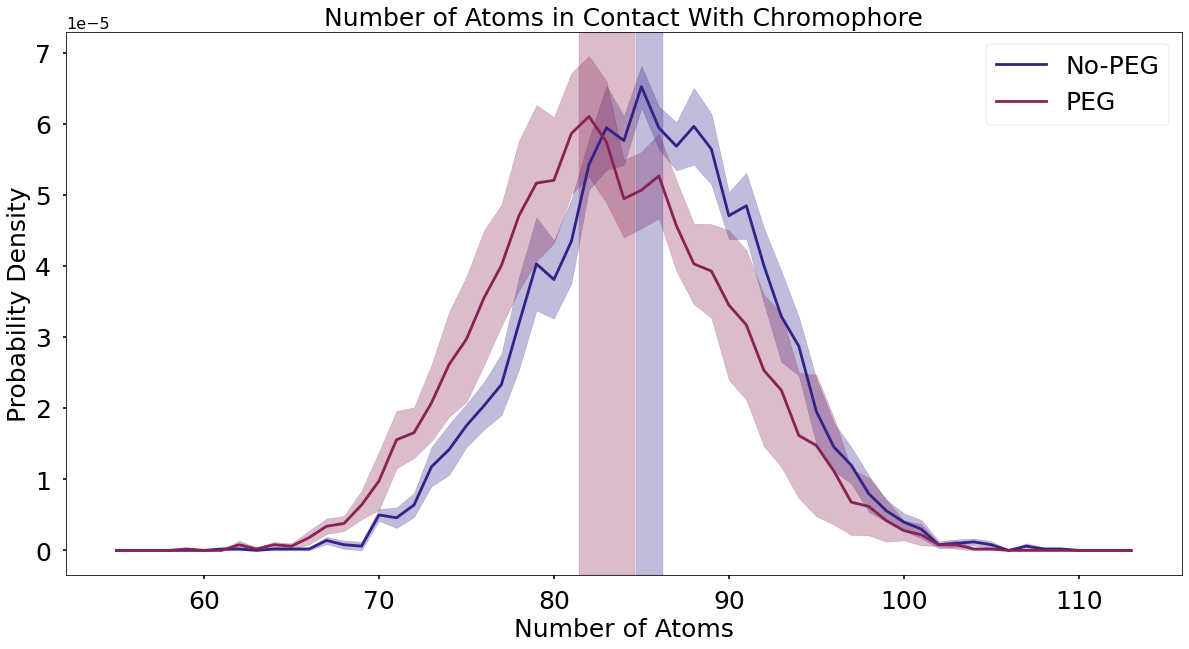

In [5]:

trjmeans = []
for i in range(len(all_total_residue_atom_counts)):
    sub = []
    for j in range(len(all_total_residue_atom_counts[i])):
        sub.append(mean(all_total_residue_atom_counts[i][j]))
    trjmeans.append(sub)
    
actualMean= [mean(trjmeans[0]),mean(trjmeans[1])]
actualSem = [scipy.stats.sem(trjmeans[0]),scipy.stats.sem(trjmeans[1])]

figure(figsize = (20,10))
plot(arange(55,115,1)[:-1],system_avg_hist_y[0],color = colourScheme[0],label = system_names[0])
plot(arange(55,115,1)[:-1],system_avg_hist_y[1],color = colourScheme[1],label = system_names[1])


fill_between(arange(55,115,1)[:-1], system_avg_hist_y[0] - system_sem_hist_y[0],system_avg_hist_y[0] + system_sem_hist_y[0],color = colourScheme[0],alpha = 0.3)
fill_between(arange(55,115,1)[:-1], system_avg_hist_y[1] - system_sem_hist_y[1],system_avg_hist_y[1] + system_sem_hist_y[1],color = colourScheme[1],alpha = 0.3)


xlabel("Number of Atoms",fontsize = 25)
ylabel("Probability Density",fontsize = 25)
title("Number of Atoms in Contact With Chromophore",fontsize = 25)
xticks(fontsize = 25)
yticks(fontsize = 25)

legend(fontsize = 25)

axvspan(actualMean[0] - actualSem[0],actualMean[0]+actualSem[0], color = colourScheme[0], alpha = 0.3)
axvspan(actualMean[1] - actualSem[1],actualMean[1]+actualSem[1], color = colourScheme[1], alpha = 0.3)


